<h1>Transfer learning and visualization for dog breed classification - </h1>

In [13]:
# Generic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import gc
from tqdm import tqdm_notebook
%matplotlib inline
sns.set_style('whitegrid')

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Keras imports
from keras.applications import VGG16, ResNet50, InceptionResNetV2
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.optimizers import RMSprop, Adam, SGD
from keras.preprocessing.image import load_img, img_to_array
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Other imports
from clr_callback import *   
import imgaug as ia
from imgaug import augmenters as iaa
from IPython.display import FileLink, FileLinks

In [14]:
# Constants
DATA_DIR = 'data/'
TRAIN_DIR = DATA_DIR + 'train/'
TEST_DIR = DATA_DIR + 'test/'
BATCH_SIZE = 128
INPUT_SIZE = 299
NUM_CLASSES = 120
SEED = 42

In [15]:
# Let's check what's in the data directory


In [16]:
# Read the train data set, which has the ids of the images and their labels (breeds)
# (adding the extension .jpg to the id becomes the file name of the image) 
train = pd.read_csv(DATA_DIR + 'labels.csv')
def append_ext(fn):
    return fn+".jpg"
train["id"]=train["id"].apply(append_ext)
train.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
2,001cdf01b096e06d78e9e5112d419397.jpg,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever


In [17]:
breeds_20 = train.breed.value_counts().head(NUM_CLASSES).index
train = train[train.breed.isin(breeds_20)]

In [19]:
# Get the breeds to pass them to the generators for creating the same labels for train set and validation set
breed_labels = list(breeds_20.values)

<h2>Transfer learning</h2>

Read the InceptionV3 base model and put on top of it a classifier suited for this problem (120 dog breeds). 

In [20]:
# Now we create our model

def create_model(lr=0.0001, dropout=None):
    
    model = Sequential()
    
    #base = InceptionV3(weights='imagenet', include_top=False, input_shape=(INPUT_SIZE, INPUT_SIZE, 3))
    #base = Xception(weights='imagenet', include_top=False, input_shape=(INPUT_SIZE, INPUT_SIZE, 3))
    #base = VGG16(weights='imagenet', include_top=False, input_shape=(INPUT_SIZE, INPUT_SIZE, 3))
    #base = ResNet50(weights='imagenet', include_top=False, input_shape=(INPUT_SIZE, INPUT_SIZE, 3))
    base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(INPUT_SIZE, INPUT_SIZE, 3))
    #base.layers.pop()   # Remove the last layer (softmax classifier)

    for layer in base.layers:
        layer.trainable = False
    
    model.add(base)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(NUM_CLASSES, activation='softmax'))

    adam = Adam(lr=lr)
    sgd = SGD(lr=0.1, momentum=0.95, nesterov=False)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['acc'],  )

    return model

In [21]:
# We split images into training (80%) and validation (20%)
train_set, val_set = train_test_split(train, test_size=0.20, stratify=train['breed'], random_state=SEED)

In [22]:
# Create the generators and data augmenters

def keypoints(keypoints_on_images, random_state, parents, hooks):
    return keypoints_on_images

def rescale_imgs(images, random_state, parents, hooks):
    for img in images:
        img = img / 255.
    return images 
    
augs = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Sometimes(0.2, iaa.Affine(rotate=(-20,20), mode='edge')),  
    iaa.SomeOf((0,4), [
        iaa.AdditiveGaussianNoise(scale=0.01*255),        
        iaa.Sharpen(alpha=(0.0,0.3)),
        iaa.ContrastNormalization((0.8,1.2)),
        iaa.AverageBlur(k=(2,11)),
        iaa.Multiply((0.8,1.2)),
        iaa.Add((-20,20), per_channel=0.5),
        iaa.Grayscale(alpha=(0.0,1.0))
    ])
    #,    iaa.Lambda(rescale_imgs, keypoints)
]) 

train_datagen = ImageDataGenerator(rescale=1./255,featurewise_center=True,
                                    featurewise_std_normalization=True,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    horizontal_flip=True)
                                    #(preprocessing_function = augs.augment_image)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(dataframe=train_set,
                                                directory=TRAIN_DIR,
                                                x_col='id',
                                                y_col='breed',
                                                class_mode='categorical',
                                                classes=breed_labels,
                                                has_ext=False,
                                                batch_size=BATCH_SIZE,
                                                shuffle=True,
                                                seed=SEED,
                                                target_size=(INPUT_SIZE, INPUT_SIZE)
                                               )

valid_generator = val_datagen.flow_from_dataframe(dataframe=val_set,
                                                directory=TRAIN_DIR,
                                                x_col='id',
                                                y_col='breed',
                                                class_mode='categorical',
                                                classes=breed_labels,
                                                has_ext=False,
                                                batch_size=BATCH_SIZE,
                                                shuffle=False,
                                                seed=SEED,target_size=(INPUT_SIZE, INPUT_SIZE)
                                               )


D:\Anaconda3\lib\site-packages\imgaug\imgaug.py:182: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


Found 8177 validated image filenames belonging to 120 classes.
Found 2045 validated image filenames belonging to 120 classes.


<h3>Search for good min and max learning rates</h3>

Now, I'll follow the guidelines to set good min and max learning rates for the cyclical learning rates approach.

In [23]:
gc.collect()

model = create_model()

train_generator.reset()
valid_generator.reset()

STEP_SIZE_TRAIN = train_set.shape[0] // BATCH_SIZE
STEP_SIZE_VALID = val_set.shape[0] // BATCH_SIZE

EPOCHS = 1
base_lr=0.0001
max_lr=1
step_size = EPOCHS * STEP_SIZE_TRAIN 
clr = CyclicLR(base_lr=base_lr, max_lr=max_lr, step_size=step_size)
model.fit_generator(train_generator, 
                              epochs=EPOCHS, 
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              callbacks=[clr]
                             )

Epoch 1/1
 2/63 [..............................] - ETA: 25:08 - loss: 4.9552 - acc: 0.0039

D:\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.710527). Check your callbacks.
  % delta_t_median)


63/63 [==============================] - 160s 3s/step - loss: 2.1006 - acc: 0.6243 - val_loss: 1.4316 - val_acc: 0.8167


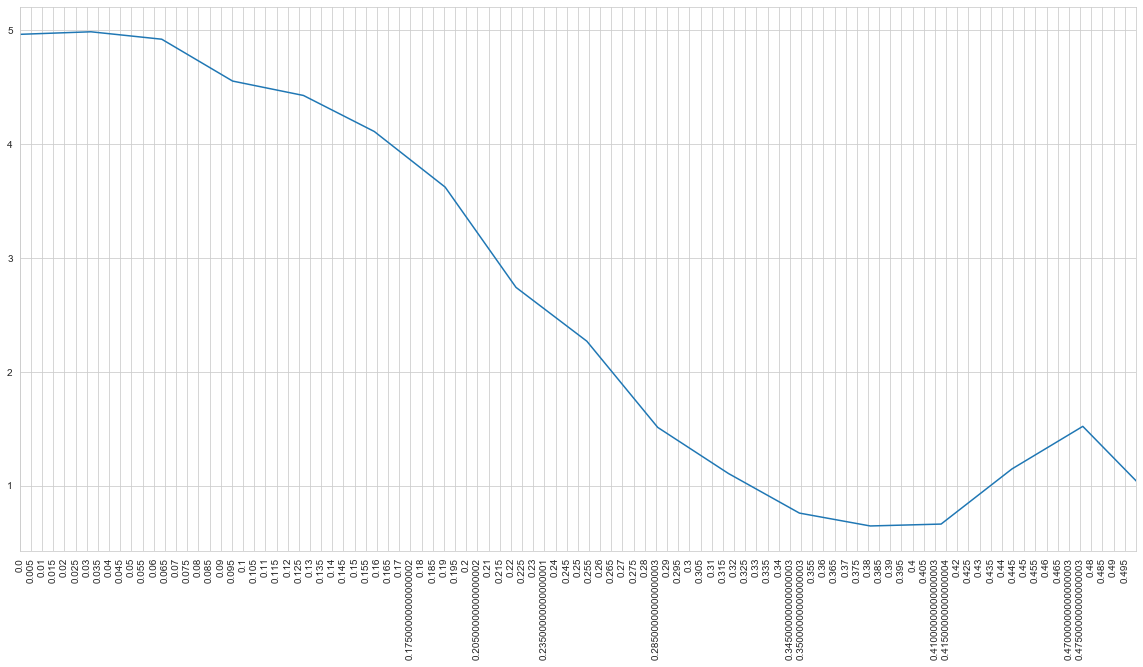

In [24]:
# Let's plot accuracies against learning rates to select the base_lr and max_lr following the article

results = pd.DataFrame(clr.history)
lr = results['lr']
loss = results['loss']
window=1
rolling_loss = loss.rolling(window).mean().fillna(0)

fig = plt.figure(figsize=(20, 10))
ticks = np.arange(0, 0.5, 0.005)
labels = ticks
plt.xticks(ticks, ticks, rotation='vertical')
plt.tick_params(axis='x', which='minor', colors='black')
#plt.xscale('log')
every = 2
#plt.ylim(4, 5.25)
plt.xlim(0,0.5)
till=500
plt.plot(lr[::every], loss[::every])
plt.show()

Following the guidelines in the cyclic learning rates article, from the previous plot, we can see that possible good values are base_lr=0.0001, max_lr=0.0.04

<h2>Training</h2>

In [25]:
# Create the model in a different cell, just in case we want to train it several times
model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1536)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)               184440    
Total params: 54,521,176
Trainable params: 184,440
Non-trainable params: 54,336,736
_________________________________________________________________


In [26]:
# Training

gc.collect()

EPOCHS=40
STEP_SIZE_TRAIN = train_set.shape[0] // BATCH_SIZE
STEP_SIZE_VALID = val_set.shape[0] // BATCH_SIZE

train_generator.reset()
valid_generator.reset()

clr = CyclicLR(base_lr=0.04, max_lr=0.11, step_size=2*STEP_SIZE_TRAIN, mode='triangular')
checkpoint = ModelCheckpoint('dog_breed_inceptionv3.hf5', monitor='val_acc', verbose=0, save_best_only=True, mode='max', save_weights_only=False)
reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr = 0.00001)
history = model.fit_generator(train_generator, 
                              epochs=EPOCHS, 
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              callbacks=[checkpoint, clr]
                            
                             )

Epoch 1/40
63/63 [==============================] - 134s 2s/step - loss: 1.9283 - acc: 0.6353 - val_loss: 0.3617 - val_acc: 0.8844
Epoch 2/40
63/63 [==============================] - 103s 2s/step - loss: 0.4618 - acc: 0.8678 - val_loss: 0.3701 - val_acc: 0.8941
Epoch 3/40
63/63 [==============================] - 101s 2s/step - loss: 0.3788 - acc: 0.8857 - val_loss: 0.3941 - val_acc: 0.8858
Epoch 4/40
63/63 [==============================] - 105s 2s/step - loss: 0.2755 - acc: 0.9107 - val_loss: 0.3685 - val_acc: 0.8878
Epoch 5/40
63/63 [==============================] - 105s 2s/step - loss: 0.2179 - acc: 0.9313 - val_loss: 0.3605 - val_acc: 0.8910
Epoch 6/40
63/63 [==============================] - 105s 2s/step - loss: 0.2084 - acc: 0.9312 - val_loss: 0.3948 - val_acc: 0.8894
Epoch 7/40
63/63 [==============================] - 106s 2s/step - loss: 0.1989 - acc: 0.9372 - val_loss: 0.3858 - val_acc: 0.8920
Epoch 8/40
63/63 [==============================] - 104s 2s/step - loss: 0.1647 - a

In [27]:
# Create a link to download the model weights
FileLink('dog_breed_inceptionv3.hf5')

D:\SJSU\advanced deep learning\dog breed\dog_breed_inceptionv3.hf5

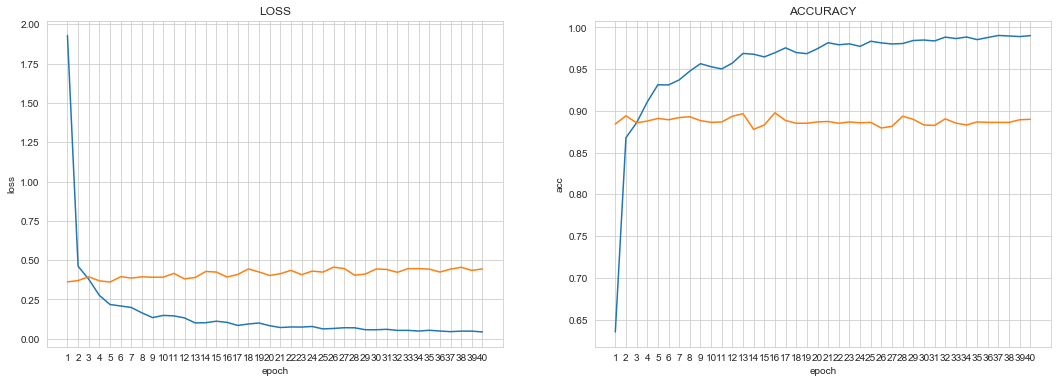

In [28]:
# Plot loss and accuracy both for train and validateion sets
def plt_history(history, metric, title, ax, val=True):
    ax.plot(history[metric])
    if val:
        ax.plot(history['val_' + metric])
    ax.grid(True)
    ax.set_title(title)
    ax.xaxis.set_ticks(range(0,EPOCHS))
    ax.xaxis.set_ticklabels([str(i) for i in range(1,EPOCHS+1)])
    

    ax.set_xlabel('epoch')
    ax.set_ylabel(metric)
    
    
hist = history.history
fig, ax = plt.subplots(1,2, figsize=(18,6))
plt_history(hist, 'loss', 'LOSS', ax[0])
plt_history(hist, 'acc', 'ACCURACY', ax[1])
plt.savefig('history.png')

In [31]:
from keras.models import load_model

model = load_model('dog_breed_inceptionv3.hf5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1536)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)               184440    
Total params: 54,521,176
Trainable params: 184,440
Non-trainable params: 54,336,736
_________________________________________________________________


In [42]:
from keras.preprocessing import image

img_path = 'data/train/0a688b0783f472c84bbfe1c56efea1c6.jpg'

# We preprocess the image into a 4D tensor
#from keras.preprocessing import image

img = image.load_img(img_path, target_size=(299, 299))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

(1, 299, 299, 3)


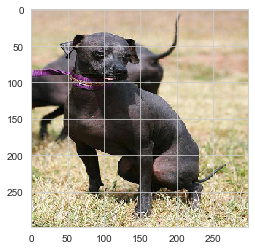

In [43]:
plt.imshow(img_tensor[0])
plt.show()

In [106]:
from keras import models

# Extracts the outputs of the top 8 layers:
#layer_outputs = [layer.output for layer in model.layers[:8]]
#layer_outputs = model.get_output_at(-1)
layer_outputs = [layer.get_output_at(-1) for layer in model.layers[:2]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [109]:
#model.layers[0].layers

In [110]:
activations = activation_model.predict(img_tensor)

In [111]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 8, 8, 1536)


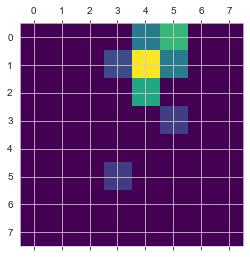

In [112]:
plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

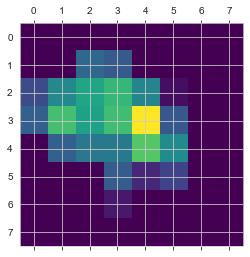

In [113]:
plt.matshow(first_layer_activation[0, :, :, 30], cmap='viridis')
plt.show()